In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams["image.origin"] = 'lower'

In [2]:
samples_base_dir = "/eos/home-d/dmapelli/public/latino/Full2017v6"
cut = "lowen_looseVBS"
version = "v7"

samples_dir = os.path.join(samples_base_dir, cut, "samples", version)
model_dir   = os.path.join(samples_base_dir, cut, "models",  version)
import os 
os.makedirs(model_dir, exist_ok=True)


In [3]:
signal = pickle.load(open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"),     "rb"))
bkg    = pickle.load(open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "rb"))

## Samples preparation for NN

In [4]:
## using 
## source /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/setup.sh
#!pip3 install --user imbalanced-learn==0.5

In [5]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from imblearn.keras import balanced_batch_generator
from imblearn.over_sampling import RandomOverSampler
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras import backend as K
from keras.callbacks import *

Using TensorFlow backend.


'mjj_vbs', 'vbs_0_pt', 'vbs_1_pt', 'vbs_0_eta', 'vbs_1_eta', 'deltaeta_vbs', 'deltaphi_vbs', 
'mjj_vjet', 'vjet_0_pt', 'vjet_1_pt', 'vjet_0_eta', 'vjet_1_eta', 'Lepton_pt', 'Lepton_eta', 
'Lepton_flavour', 'PuppiMET', 'nJets', 'N_jets_central', 'N_jets_forward', 'Zvjets_0', 
'Zlep', 'Asym_vbs', 'Asym_vjet', 'A_ww', 'Mw_lep_reco', 'Mtw_lep', 'w_lep_pt', 'Mww', 'R_ww', 'R_mw', 'Centr_vbs', 'Centr_ww

In [6]:
import yaml
yaml_vars = yaml.safe_load(open(os.path.join(model_dir, "variables.yml")))
print(type(yaml_vars), yaml_vars)
cols = yaml_vars

<class 'list'> ['mjj_vbs', 'vbs_0_pt', 'vbs_1_pt', 'vbs_0_eta', 'vbs_1_eta', 'deltaeta_vbs', 'deltaphi_vbs', 'mjj_vjet', 'vjet_0_pt', 'vjet_1_pt', 'vjet_0_eta', 'vjet_1_eta', 'Lepton_pt', 'Lepton_eta', 'Lepton_flavour', 'PuppiMET', 'nJets', 'N_jets_central', 'N_jets_forward', 'Zvjets_0', 'Zlep', 'Asym_vbs', 'Asym_vjet', 'A_ww', 'Mw_lep_reco', 'Mtw_lep', 'w_lep_pt', 'Mww', 'R_ww', 'R_mw', 'Centr_vbs', 'Centr_ww']


In [7]:
X_sig = signal[cols].values
X_bkg = bkg[cols].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values

In [8]:
X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(f"{model_dir}/scaler_model.pkl", "wb"))

vjet_0_eta


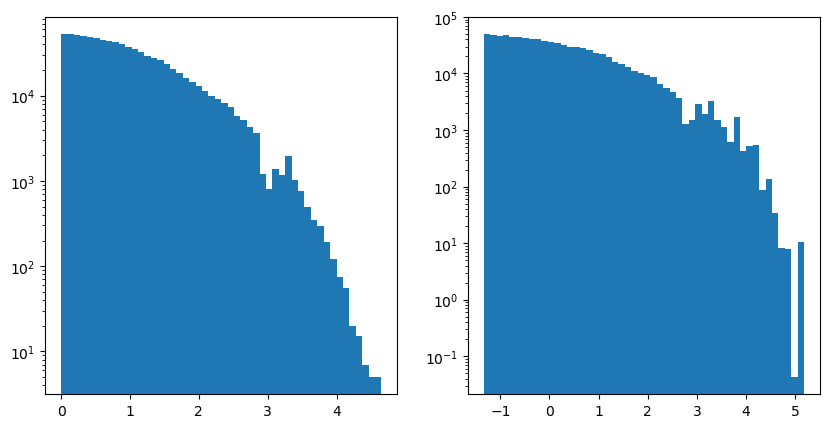

In [10]:
i = 10
print(cols[i])
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5), dpi=100)
ax1.hist(X[:,i], bins=50)
ax1.set_yscale("log")
ax2.hist(X_scaled[:,i], weights=W, bins=50)
plt.yscale("log")

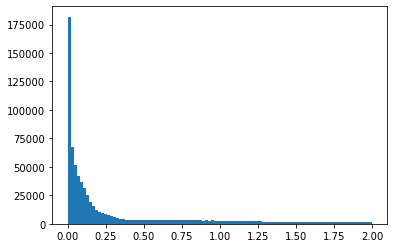

In [11]:
_ = plt.hist(W, bins=100, range=(0,2))

##  Balancing
Let's give 25% to validation (validation during training + test). 
The validation is then split in 50%-50% for training validation and final result

In [12]:
X_train, X_temp, y_train, y_temp, W_train, W_temp = train_test_split(X_scaled, Y,      W,      test_size=0.25)
X_val,   X_test, y_val,   y_test, W_val,   W_test = train_test_split(X_temp,   y_temp, W_temp, test_size=0.5)

In [28]:
print("Training dataset: ", X_train.shape)

Training dataset:  (632280, 32)


Create generators to balance signal and background

In [14]:
training_generator,   steps_per_epoch_train = balanced_batch_generator(X_train, y_train, W_train, batch_size=1024, sampler=RandomOverSampler())
validation_generator, steps_per_epoch_val   = balanced_batch_generator(X_val,   y_val,   W_val,   batch_size=1024, sampler=RandomOverSampler())

## Keras model

In [15]:
model = Sequential()
model.add(Dense(100, input_dim=X_train.shape[1], activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(80, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

W0128 15:24:22.223883 140453911623488 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0128 15:24:22.245102 140453911623488 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0128 15:24:22.250231 140453911623488 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0128 15:24:22.292778 140453911623488 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x8

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               3300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 80)                8080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                4050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total para

In [16]:
## callbacks

# auto_save = ModelCheckpoint("../models/model12_balanced_100_50.hd5", monitor='val_loss', 
#                     verbose=1, save_best_only=True, save_weights_only=False, 
#                     mode='auto', period=5)
#
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
#                             patience=10, verbose=1)

In [17]:
## In case you do not want to use the generators

# history = model.fit(
#             X_train,y_train, 
#             sample_weight=W_train, 
#             epochs=50,
#             validation_data = (X_val, y_val, W_val),
#             batch_size=1024,
#             shuffle=True 
#             )

In [18]:
history = model.fit_generator(
            training_generator, 
            epochs=300,
            #initial_epoch=200,
            steps_per_epoch=steps_per_epoch_train, 
            validation_data = validation_generator, 
            validation_steps = steps_per_epoch_val,
            callbacks = [], 
            )

Epoch 1/300
1054/1054 [==============================] - 7s 7ms/step - loss: 0.5679 - acc: 0.5664 - val_loss: 0.5467 - val_acc: 0.5745
Epoch 2/300
1054/1054 [==============================] - 6s 6ms/step - loss: 0.5476 - acc: 0.5834 - val_loss: 0.5403 - val_acc: 0.5820
Epoch 3/300
1054/1054 [==============================] - 6s 6ms/step - loss: 0.5397 - acc: 0.5872 - val_loss: 0.5367 - val_acc: 0.5776
Epoch 4/300
1054/1054 [==============================] - 7s 6ms/step - loss: 0.5347 - acc: 0.5914 - val_loss: 0.5338 - val_acc: 0.5832
Epoch 5/300
1054/1054 [==============================] - 6s 6ms/step - loss: 0.5323 - acc: 0.5925 - val_loss: 0.5339 - val_acc: 0.5843
Epoch 6/300
1054/1054 [==============================] - 6s 6ms/step - loss: 0.5307 - acc: 0.5930 - val_loss: 0.5333 - val_acc: 0.5797
Epoch 7/300
1054/1054 [==============================] - 6s 6ms/step - loss: 0.5285 - acc: 0.5956 - val_loss: 0.5314 - val_acc: 0.5884
Epoch 8/300
1054/1054 [==============================] 

1054/1054 [==============================] - 6s 6ms/step - loss: 0.5124 - acc: 0.6098 - val_loss: 0.5295 - val_acc: 0.5974
Epoch 62/300
1054/1054 [==============================] - 6s 6ms/step - loss: 0.5103 - acc: 0.6109 - val_loss: 0.5305 - val_acc: 0.6018
Epoch 63/300
1054/1054 [==============================] - 6s 6ms/step - loss: 0.5110 - acc: 0.6090 - val_loss: 0.5296 - val_acc: 0.6116
Epoch 64/300
1054/1054 [==============================] - 6s 6ms/step - loss: 0.5099 - acc: 0.6108 - val_loss: 0.5288 - val_acc: 0.6137
Epoch 65/300
1054/1054 [==============================] - 6s 6ms/step - loss: 0.5115 - acc: 0.6089 - val_loss: 0.5298 - val_acc: 0.6049
Epoch 66/300
1054/1054 [==============================] - 6s 6ms/step - loss: 0.5097 - acc: 0.6115 - val_loss: 0.5316 - val_acc: 0.6152
Epoch 67/300
1054/1054 [==============================] - 6s 6ms/step - loss: 0.5107 - acc: 0.6123 - val_loss: 0.5310 - val_acc: 0.6129
Epoch 68/300
1054/1054 [==============================] - 6s 

1054/1054 [==============================] - 6s 6ms/step - loss: 0.5062 - acc: 0.6133 - val_loss: 0.5314 - val_acc: 0.6148
Epoch 122/300
1054/1054 [==============================] - 6s 6ms/step - loss: 0.5057 - acc: 0.6135 - val_loss: 0.5320 - val_acc: 0.6188
Epoch 123/300
1054/1054 [==============================] - 6s 6ms/step - loss: 0.5066 - acc: 0.6141 - val_loss: 0.5318 - val_acc: 0.6170
Epoch 124/300
1054/1054 [==============================] - 6s 6ms/step - loss: 0.5058 - acc: 0.6151 - val_loss: 0.5324 - val_acc: 0.6186
Epoch 125/300
1054/1054 [==============================] - 6s 6ms/step - loss: 0.5060 - acc: 0.6152 - val_loss: 0.5331 - val_acc: 0.6143
Epoch 126/300
1054/1054 [==============================] - 6s 6ms/step - loss: 0.5067 - acc: 0.6134 - val_loss: 0.5319 - val_acc: 0.6123
Epoch 127/300
1054/1054 [==============================] - 6s 6ms/step - loss: 0.5068 - acc: 0.6153 - val_loss: 0.5322 - val_acc: 0.6153
Epoch 128/300
1054/1054 [==============================

Epoch 181/300
1054/1054 [==============================] - 6s 6ms/step - loss: 0.5044 - acc: 0.6173 - val_loss: 0.5328 - val_acc: 0.6202
Epoch 182/300
1054/1054 [==============================] - 6s 6ms/step - loss: 0.5034 - acc: 0.6180 - val_loss: 0.5337 - val_acc: 0.6206
Epoch 183/300
1054/1054 [==============================] - 6s 6ms/step - loss: 0.5042 - acc: 0.6184 - val_loss: 0.5337 - val_acc: 0.6238
Epoch 184/300
1054/1054 [==============================] - 6s 6ms/step - loss: 0.5038 - acc: 0.6180 - val_loss: 0.5335 - val_acc: 0.6173
Epoch 185/300
1054/1054 [==============================] - 6s 6ms/step - loss: 0.5039 - acc: 0.6181 - val_loss: 0.5345 - val_acc: 0.6151
Epoch 186/300
1054/1054 [==============================] - 6s 6ms/step - loss: 0.5042 - acc: 0.6164 - val_loss: 0.5335 - val_acc: 0.6209
Epoch 187/300
1054/1054 [==============================] - 6s 6ms/step - loss: 0.5054 - acc: 0.6166 - val_loss: 0.5332 - val_acc: 0.6184
Epoch 188/300
1054/1054 [================

Epoch 241/300
1054/1054 [==============================] - 7s 6ms/step - loss: 0.5035 - acc: 0.6212 - val_loss: 0.5335 - val_acc: 0.6218
Epoch 242/300
1054/1054 [==============================] - 7s 6ms/step - loss: 0.5028 - acc: 0.6216 - val_loss: 0.5327 - val_acc: 0.6238
Epoch 243/300
1054/1054 [==============================] - 7s 6ms/step - loss: 0.5027 - acc: 0.6207 - val_loss: 0.5326 - val_acc: 0.6207
Epoch 244/300
1054/1054 [==============================] - 7s 6ms/step - loss: 0.5026 - acc: 0.6196 - val_loss: 0.5332 - val_acc: 0.6213
Epoch 245/300
1054/1054 [==============================] - 6s 6ms/step - loss: 0.5034 - acc: 0.6219 - val_loss: 0.5324 - val_acc: 0.6186
Epoch 246/300
1054/1054 [==============================] - 7s 6ms/step - loss: 0.5020 - acc: 0.6189 - val_loss: 0.5337 - val_acc: 0.6174
Epoch 247/300
1054/1054 [==============================] - 7s 6ms/step - loss: 0.5031 - acc: 0.6187 - val_loss: 0.5331 - val_acc: 0.6151
Epoch 248/300
1054/1054 [================

In [19]:
model.save(f"{model_dir}/model.h5")

>>> Computing AUC...


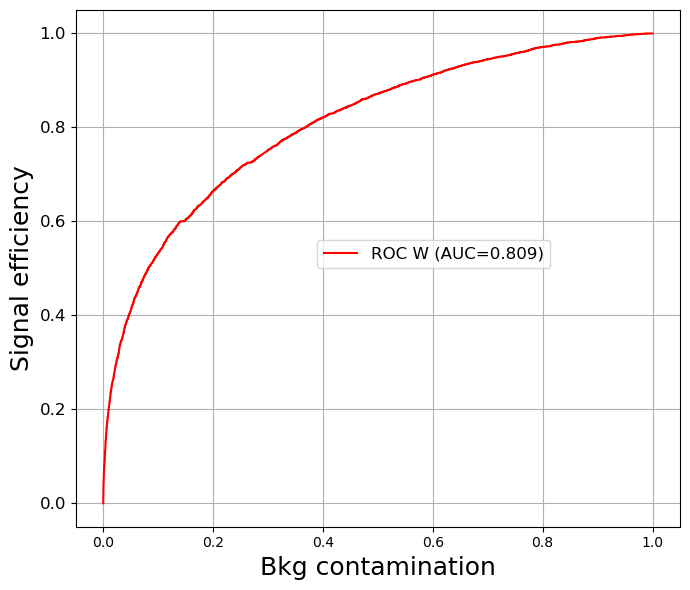

In [39]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve

pred = model.predict(X_test)
auc = roc_auc_score(y_test,pred)
auc_w = roc_auc_score(y_test,pred, sample_weight=W_test)
fpW, tpW, thW = roc_curve(y_test, pred, sample_weight=W_test)
fp, tp, th = roc_curve(y_test, pred)
#print("AUC score: " + str(auc))

fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

# ax1.plot(fp, tp, label=f"ROC (AUC={auc:.3f})", color="blue")
ax1.plot(fpW, tpW, label=f"ROC W (AUC={auc_w:.3f})", color="red")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18)

#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large")

ax1.grid()

ax1.legend(loc=(0.4, 0.5), fontsize="large")

fig.tight_layout()

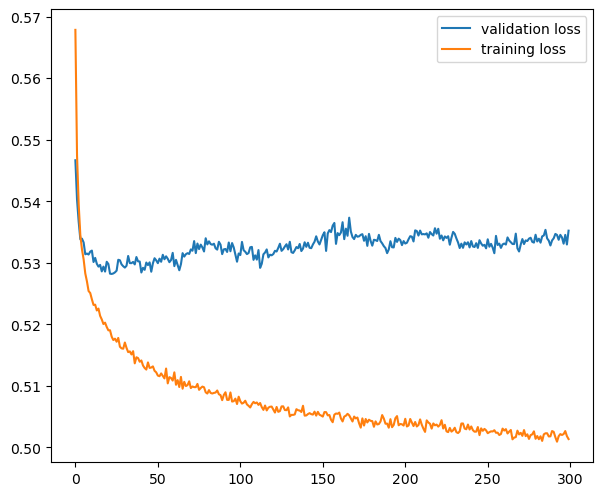

In [21]:
fig, ax = plt.subplots(figsize=(7,6), dpi=100)
ax.plot(history.epoch, history.history["val_loss"], label="validation loss")
ax.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

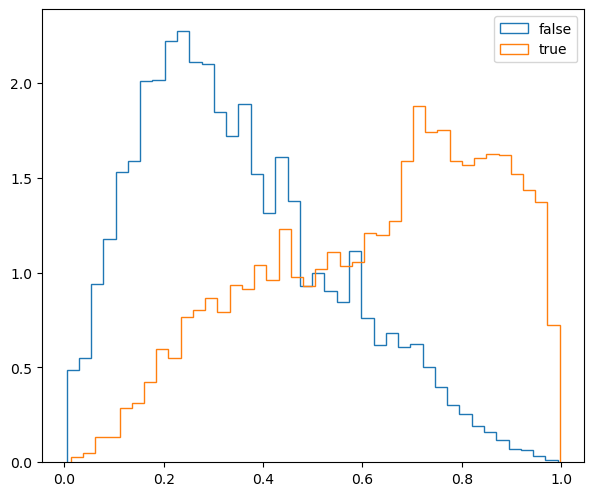

In [22]:
results = model.predict(X_test, batch_size=2048)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(results[y_test==0],weights=W_test[y_test==0], bins=40,density=True, label="false", histtype="step")
plt.hist(results[y_test==1],weights=W_test[y_test==1], bins=40, density=True, label="true", histtype="step")
#plt.yscale("log")
plt.legend()

## Evaluation by sample

In [23]:
bkg["y"] = model.predict(scaler.transform(bkg[cols].values), batch_size=2048)

In [24]:
signal["y"] = model.predict(scaler.transform(signal[cols].values), batch_size=2048)

In [25]:
wjets = bkg[bkg["sample_name"] == "Wjets"]
top = bkg[bkg["sample_name"] == "top"]
dy = bkg[bkg["sample_name"] == "DY"]

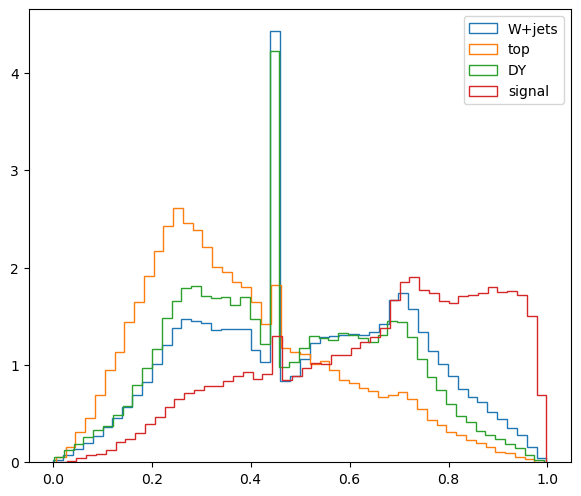

In [26]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(bkg[bkg["sample_name"] == "Wjets"]["y"], bins=50, density=True, label="W+jets", histtype="step")
plt.hist(bkg[bkg["sample_name"] == "top"]["y"],   bins=50, density=True, label="top",    histtype="step")
plt.hist(bkg[bkg["sample_name"] == "DY"]["y"],    bins=50, density=True, label="DY",     histtype="step")

plt.hist(signal["y"], bins=50,density=True, label="signal", histtype="step")
#plt.yscale("log")
plt.legend()

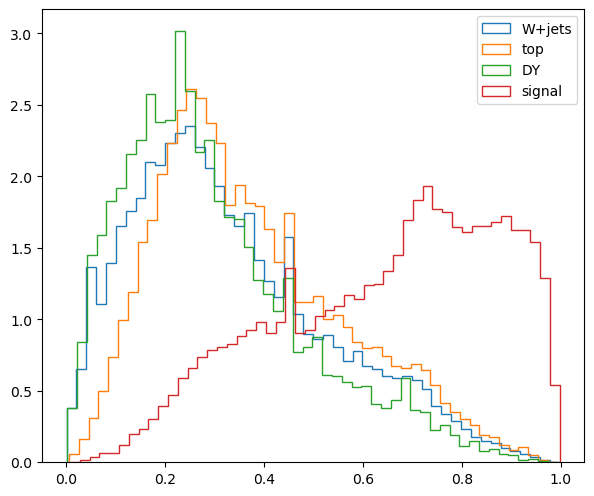

In [27]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(wjets["y"], weights=wjets.weight_norm, bins=50, density=True, label="W+jets", histtype="step")
plt.hist(top["y"],   weights=top.weight_norm,  bins=50, density=True, label="top",    histtype="step")
plt.hist(dy["y"],    weights=dy.weight_norm,  bins=50, density=True, label="DY",     histtype="step")

plt.hist(signal["y"], weights=signal.weight_norm, bins=50,density=True, label="signal", histtype="step")
#plt.yscale("log")
plt.legend()